In [13]:
suppressPackageStartupMessages(source("/Users/klagattu/Downloads/tcrpheno_analysis_github/utils.R"))
setwd("/Users/klagattu/Downloads/tcrpheno_analysis_github/data")

In [3]:
metadata = read.csv("PAN.A01.v01.raw_count.20210429.NKT_metadata.csv", header=TRUE)

In [4]:
metadata = metadata[metadata$mito<.1,]
metadata = metadata[metadata$n_genes>=500,]

In [5]:
tcr = readRDS("suo_pairedTCRdf.rds")
tcr = label_invariants2(tcr)
metadata = left_join(metadata, tcr)

Joining, by = c("n_counts", "n_genes", "file", "mito", "doublet_scores", "predicted_doublets", "old_annotation_uniform", "organ", "Sort_id", "age", "method", "donor", "sex", "Sample", "scvi_clusters", "is_maternal_contaminant", "anno_lvl_2_final_clean", "celltype_annotation")


In [55]:
tcrscores = readRDS("suo_LR0606scores_scaled.rds")

In [56]:
tcrscores$index = rownames(tcrscores)
tcrscores = left_join(tcrscores, metadata)

Joining, by = "index"


In [57]:
t = table(tcrscores$donor)
tcrscores = tcrscores[tcrscores$donor %in% names(t)[t>=100],] #require at least 100 clones per donor

In [58]:
tcrscores$tphase = "other"
tcrscores$tphase[grepl("DN", tcrscores$celltype_annotation)] = "DN"
tcrscores$tphase[grepl("DP", tcrscores$celltype_annotation)] = "DP"
tcrscores$tphase[tcrscores$celltype_annotation %in% c("CD4+T", "CD8+T", "TREG")] = "SP"

## Figure 5a

Joining, by = "qtl"


# A tibble: 3 × 7
  effect   group term            estimate std.error statistic      p.value
  <chr>    <chr> <chr>              <dbl>     <dbl>     <dbl>        <dbl>
1 fixed    NA    (Intercept)      -0.0456    0.393     -0.116  0.908      
2 fixed    NA    TCRscore          0.135     0.0269     5.02   0.000000259
3 ran_pars Donor sd__(Intercept)   0.959    NA         NA     NA          


`summarise()` has grouped output by 'bin'. You can override using the `.groups` argument.
Joining, by = "bin"


# A tibble: 5 × 9
     bin    OR lowOR highOR term                  lcat     qtl minbin maxbin
   <dbl> <dbl> <dbl>  <dbl> <chr>                 <chr>  <dbl>  <dbl>  <dbl>
1 -1.40   1.07 0.912   1.25 bin-1.39527032063685  thymus    20 -3.79  -0.877
2 -0.106  1.11 0.948   1.30 bin-0.105627859203405 thymus    60 -0.341  0.129
3  0.412  1.31 1.11    1.53 bin0.411975288516189  thymus    80  0.130  0.719
4  1.30   1.48 1.26    1.74 bin1.30156390770633   thymus   100  0.719  3.39 
5 -0.601  1    1       1    ref                   thymus    40 -0.877 -0.342


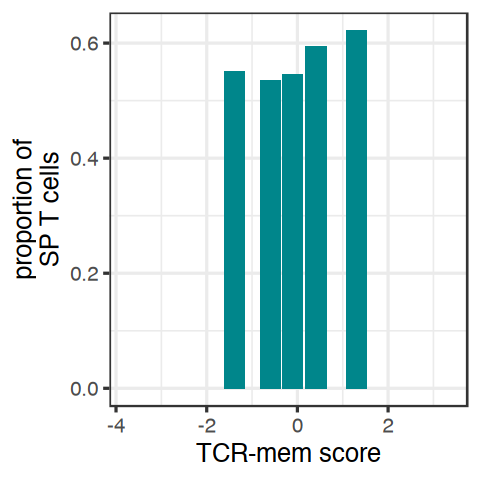

In [19]:
tmp = tcrscores[tcrscores$tphase %in% c("DP", "SP"),]
tmp$Donor = tmp$donor
tmp$lcat = "thymus"
tmp$target4 = tmp$tphase=="SP"
res = plot_TCRscore_validation_bybin(tmp, 4, lcat="thymus", colors = c("turquoise4"), xlab = "TCR-mem score", ylab = "proportion of\nSP T cells", quantile_bin=0.2, thresh=0, show.legend = FALSE, fate="SP")
options(repr.plot.height=4, repr.plot.width=4)
res[[1]]

In [28]:
bld = readRDS("stephenson_LR0606scores_scaled.rds")

In [29]:
md = read.csv("stephenson_metadata.csv", header=TRUE)
cl1 = readRDS("stephenson_QCnoLPS_Tselect0326_mappedto_COMBATfull_wcl0.5_5kpreds.rds")
md = md[md$covid_index %in% cl1$covid_index,] ##pass RNAqc
md$target1 = md$covid_index %in% cl1$covid_index[cl1$pred=="8"]
cl2 = readRDS("stephenson_QCnoLPS_Tselect0326_mappedto_COMBATfull_w5kpreds_cl2.0.rds")
s.cmem = readRDS("stephenson_QCnoLPS_Tselect0326_mappedto_COMBATcmem0405_w5kpreds.rds")
md$target4 = md$covid_index %in% s.cmem$covid_index[!(grepl("naive", s.cmem$pred))]
md$target4[md$target1==TRUE] = NA
bld = left_join(bld, md[,c("target4", "covid_index", "patient_id")], by=c("cell"="covid_index"))

In [46]:
thy = tcrscores[tcrscores$tphase %in% c("DP", "SP"),]
df = data.frame(data = c(rep("thymus", nrow(thy)), rep("blood", nrow(bld))), donor = c(thy$donor, bld$patient_id), cell = c(thy$index, bld$cell), TCRmem = c(thy$X4, bld$X4), target4 = c(thy$tphase=="SP", bld$target4))

In [47]:
qu = quantile(df$TCRmem, probs=seq(0.1, 1, by=0.1))
df$qu = sapply(df$TCRmem, function(x) names(qu)[min(which(qu>=x))])
gr = df %>% group_by(qu) %>% dplyr::summarise(meanTCRmem = mean(TCRmem))
df = left_join(df, gr)
cols = c("bin", "OR", "lowOR", "highOR", "term")
df$bin = df$meanTCRmem
df$Donor = df$donor
df$target = df$target4
st.thy = get_bin_stats(df[df$data=="thymus",], cols, quantile_bin=0.1)
st.bld = get_bin_stats(df[df$data!="thymus",], cols, quantile_bin=0.1)

Joining, by = "qu"


In [48]:
st.thy = st.thy[,2:5]
colnames(st.thy)[1:3] = paste(colnames(st.thy)[1:3], ".thy", sep="")
st.bld = st.bld[,2:5]
colnames(st.bld)[1:3] = paste(colnames(st.bld)[1:3], ".bld", sep="")

## Figure 5b

Joining, by = "term"
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


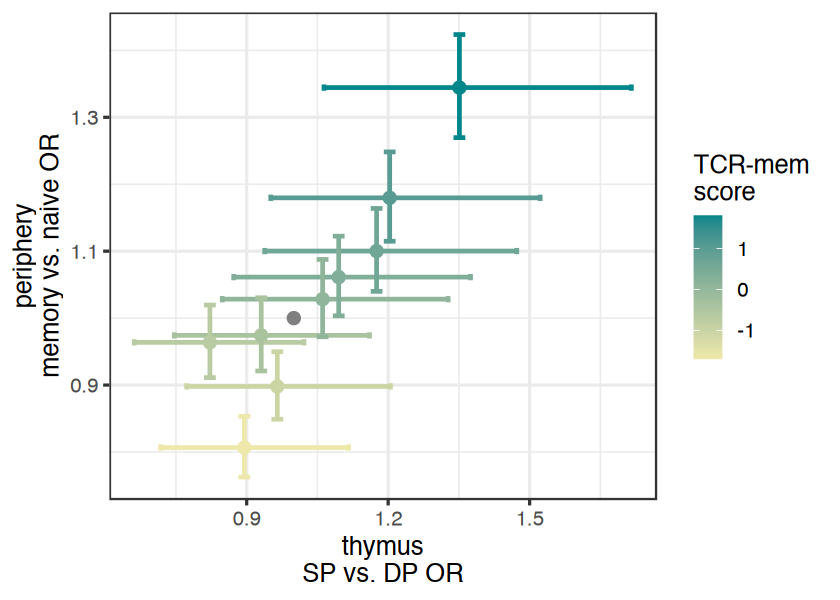

In [49]:
options(repr.plot.height=5, repr.plot.width=7)
tp = full_join(st.thy, st.bld)
tp = tp[!(grepl("Intercept", as.character(tp$term))),]
tp$meanTCRmem = as.numeric(as.character(gsub("bin", "", as.character(tp$term))))
g = ggplot(tp, aes(OR.thy, OR.bld, color=meanTCRmem))
g = g + geom_errorbar(aes(xmin=lowOR.thy, xmax=highOR.thy), size=1)
g = g + geom_errorbar(aes(ymin=lowOR.bld, ymax=highOR.bld), size=1) + theme_bw(base_size=15)
g =g + geom_point(size=3)
g = g + scale_color_gradient(low="palegoldenrod", high="turquoise4")
g = g + xlab("thymus\nSP vs. DP OR") + ylab("periphery\nmemory vs. naive OR")
g + labs(color="TCR-mem\nscore")

In [44]:
igor.thy = process_igor_output("suo_igorresults_117.rds")

In [59]:
tcrscores = left_join(tcrscores, igor.thy[,c("id", "ab_ins")], by=c("index"="id"))

In [61]:
tcrscores$TCRmem.dcl = convert_to_quantile(tcrscores$X4, step=0.1)
tcrscores$ab_ins = as.numeric(as.character(tcrscores$ab_ins))
tcrscores$ab_ins2 = as.character(tcrscores$ab_ins)
tcrscores$ab_ins2[tcrscores$ab_ins>=10] = "10+"
ins.gr = tcrscores[!(is.na(tcrscores$TCRmem.dcl)) & tcrscores$tphase %in% c("SP", "DP"),] %>% group_by(ab_ins2, TCRmem.dcl) %>% dplyr::summarise(p = length(tphase[tphase=="SP"])/length(tphase),
                                                               meanTCRmem = mean(X4, na.rm=TRUE), n = length(tphase))


`summarise()` has grouped output by 'ab_ins2'. You can override using the `.groups` argument.


## Figure 5c

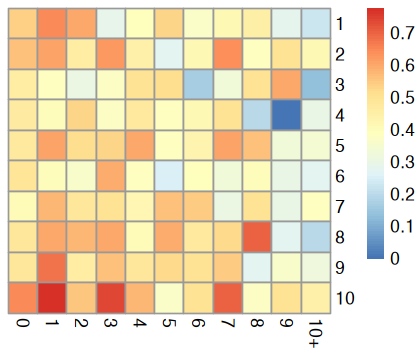

In [64]:
options(repr.plot.height=3, repr.plot.width=3.5)
ins.gr$odds = sapply(ins.gr$p, function(x) x/(1-x))
tpl = ins.gr[,c("ab_ins2", "TCRmem.dcl", "p")]
tp = data.frame(pivot_wider(tpl, names_from=ab_ins2, values_from=p))
rownames(tp) = tp$TCRmem.dcl
tp = tp[,c(paste("X", seq(0, 9), sep=""), "X10.")]
colnames(tp) = c(as.character(seq(0, 9)), "10+")
rownames(tp) = seq(1, 10)
pheatmap(tp, cluster_rows = FALSE, cluster_cols = FALSE)

## Figure 5d

Joining, by = "qtl"


# A tibble: 3 × 7
  effect   group term            estimate std.error statistic   p.value
  <chr>    <chr> <chr>              <dbl>     <dbl>     <dbl>     <dbl>
1 fixed    NA    (Intercept)       -0.253    0.215      -1.18  2.39e- 1
2 fixed    NA    TCRscore           0.422    0.0265     16.0   1.26e-57
3 ran_pars Donor sd__(Intercept)    0.513   NA          NA    NA       


`summarise()` has grouped output by 'bin'. You can override using the `.groups` argument.
Joining, by = "bin"


# A tibble: 5 × 9
      bin    OR lowOR highOR term                  lcat     qtl minbin maxbin
    <dbl> <dbl> <dbl>  <dbl> <chr>                 <chr>  <dbl>  <dbl>  <dbl>
1 -1.38   0.775 0.659  0.912 bin-1.3764801049712   thymus    20 -3.43  -0.810
2  0.0762 1.23  1.05   1.45  bin0.0762464741016675 thymus    60 -0.198  0.348
3  0.662  1.49  1.26   1.75  bin0.661744258744429  thymus    80  0.348  1.00 
4  1.60   2.92  2.46   3.47  bin1.59820783868035   thymus   100  1.00   3.72 
5 -0.485  1     1      1     ref                   thymus    40 -0.810 -0.198


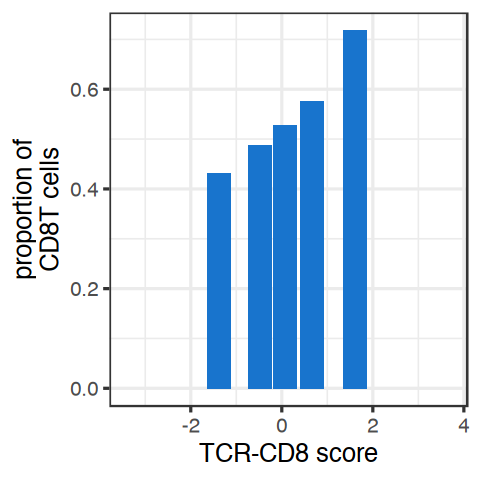

In [20]:
tmp = tcrscores[tcrscores$celltype_annotation %in% c("CD4+T", "CD8+T", "CD8AA", "TREG"),]
tmp$Donor = tmp$donor
tmp$lcat = "thymus"
tmp$target2 = grepl("CD8", tmp$celltype_annotation) 
res = plot_TCRscore_validation_bybin(tmp, 2, lcat="thymus", colors = c("dodgerblue3"), xlab = "TCR-CD8 score", ylab = "proportion of\nCD8T cells", quantile_bin=0.2, thresh=0, show.legend = FALSE, fate="CD8T")
options(repr.plot.height=4, repr.plot.width=4)
res[[1]]

## Figure 5e

Joining, by = "qtl"


# A tibble: 3 × 7
  effect   group term            estimate std.error statistic   p.value
  <chr>    <chr> <chr>              <dbl>     <dbl>     <dbl>     <dbl>
1 fixed    NA    (Intercept)       -0.958    0.0983     -9.75  1.90e-22
2 fixed    NA    TCRscore           0.157    0.0349      4.51  3.31e- 6
3 ran_pars Donor sd__(Intercept)    0.196   NA          NA    NA       


`summarise()` has grouped output by 'bin'. You can override using the `.groups` argument.
Joining, by = "bin"


# A tibble: 5 × 9
     bin    OR lowOR highOR term                 lcat     qtl  minbin  maxbin
   <dbl> <dbl> <dbl>  <dbl> <chr>                <chr>  <dbl>   <dbl>   <dbl>
1 -1.08   1.00 0.797   1.26 bin-1.07856623196245 thymus    20 -3.00   -0.573 
2  0.267  1.09 0.870   1.37 bin0.267318693434908 thymus    60  0.0215  0.519 
3  0.820  1.31 1.05    1.63 bin0.819944884392779 thymus    80  0.520   1.16  
4  1.77   1.40 1.12    1.74 bin1.77418089856789  thymus   100  1.16    3.80  
5 -0.268  1    1       1    ref                  thymus    40 -0.573   0.0213


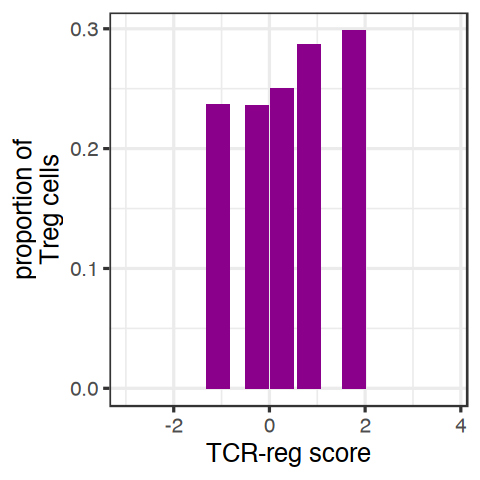

In [21]:
tmp = tcrscores[tcrscores$celltype_annotation %in% c("TREG", "CD4+T", "CD8+T"),]
tmp$Donor = tmp$donor
tmp$lcat = "thymus"
tmp$target3 = tmp$celltype_annotation=="TREG"
res = plot_TCRscore_validation_bybin(tmp, 3, lcat="thymus", colors = c("darkmagenta"), xlab = "TCR-reg score", ylab = "proportion of\nTreg cells", quantile_bin=0.2, thresh=0, show.legend = FALSE, fate="Treg")
options(repr.plot.height=4, repr.plot.width=4)
res[[1]]